ARBRES DE DECISION:

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

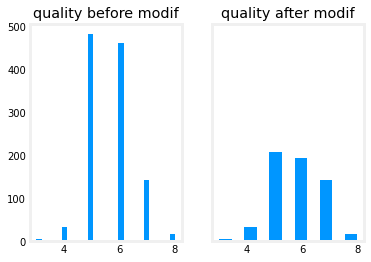

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

In [18]:
X_train = X_norm2

y_train = y_train2

In [34]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


In [27]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

def split_indices_continue(X,t, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[0,index_feature] >= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [30]:
left,right=split_indices_continue(X_train,0.5, 0)
print(X_train)
print(len(left),len(right))

[[ 0.7    9.4    0.56   0.   ]
 [ 0.88   9.8    0.68   0.   ]
 [ 0.76   9.8    0.65   0.04 ]
 ...
 [ 0.6   10.5    0.58   0.08 ]
 [ 0.55  11.2    0.76   0.1  ]
 [ 0.645 10.2    0.71   0.12 ]]
639 504


In [51]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    print(p_left)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

def weighted_entropy_continue(X,y,left_indices,right_indices,threshold_y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)

    #calcul p_left et p_right : moyenne de Y>threshold_y(qualité du vin) (moyenne d'un tableau de 1 0 1 00 1...)
    p_left=np.mean(y[left_indices]>=threshold_y)
    p_right=np.mean(y[right_indices]>=threshold_y)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [52]:
left_indices, right_indices = split_indices_continue(X_train,0.5, 0)
weighted_entropy_continue(X_train, y_train, left_indices, right_indices,5)

0.20507470658916765

In [53]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

def information_gain_continue(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [54]:
information_gain(X_train, y_train, left_indices, right_indices)

5.420970266040689


/tmp/ipykernel_31902/4116822562.py:5: RuntimeWarning: invalid value encountered in log2
  return -p * np.log2(p) - (1- p)*np.log2(1 - p)


nan

In [27]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")

Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


In [31]:
def compute_entropy(y):

    entropy = 0
    
    if len(y) == 0:
        return 0
    entropy = sum(y[y==1])/len(y)
    if entropy == 0 or entropy == 1:
        return 0
    else:
        return -entropy*np.log2(entropy) - (1-entropy)*np.log2(1-entropy)
     

def split_dataset(X, node_indices, feature):

    left_indices = []
    right_indices = []

    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 
def compute_information_gain(X, y, node_indices, feature):
    
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain
def get_best_split(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature
    print("max_info_gain",max_info_gain)
   
    return best_feature
def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   

    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    

    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

In [29]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=1, current_depth=0, tree = tree)

 Depth 0, Root: Split on feature: 0
 - Left leaf node with indices [0, 3, 4, 5, 7]
 - Right leaf node with indices [1, 2, 6, 8, 9]


[([0, 3, 4, 5, 7], [1, 2, 6, 8, 9], 0)]

In [32]:
tree = []
build_tree_recursive(X_train, y_train, [0,1,2,3,4,5,6,7,8,9], "Root", max_depth=3, current_depth=0, tree = tree)

max_info_gain 0.2780719051126377
 Depth 0, Root: Split on feature: 0
max_info_gain 0.7219280948873623
- Depth 1, Left: Split on feature: 1
max_info_gain 0
-- Depth 2, Left: Split on feature: -1
   --- Left leaf node with indices [0, 4, 5, 7]
   --- Right leaf node with indices []
max_info_gain 0
-- Depth 2, Right: Split on feature: -1
   --- Left leaf node with indices [3]
   --- Right leaf node with indices []
max_info_gain 0.7219280948873623
- Depth 1, Right: Split on feature: 2
max_info_gain 0
-- Depth 2, Left: Split on feature: -1
   --- Left leaf node with indices [1]
   --- Right leaf node with indices []
max_info_gain 0
-- Depth 2, Right: Split on feature: -1
   --- Left leaf node with indices [2, 6, 8, 9]
   --- Right leaf node with indices []


[([0, 3, 4, 5, 7], [1, 2, 6, 8, 9], 0),
 ([0, 4, 5, 7], [3], 1),
 ([0, 4, 5, 7], [], -1),
 ([3], [], -1),
 ([1], [2, 6, 8, 9], 2),
 ([1], [], -1),
 ([2, 6, 8, 9], [], -1)]

TREE ENSEMBLES : RANDOM FOREST POUR LA QUALITE DU VIN

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

prep données

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

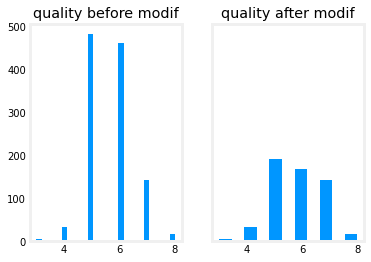

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

In [3]:
X_train=X_norm2
y_train=y_train2
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
print(int(len(y_train)*0.8)) ## Let's use 80% to train and 20% to eval

from sklearn.preprocessing import LabelEncoder
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print(y_train)

447
[5 6 5 7 7 5 7 5 5 5 6 5 6 6 7 4 6 4 5 6 5 5 4 5 6 5 4 5 5 5 4 5 5 5 5 5 6
 6 5 5 7 5 5 5 5 5 6 4 5 5 5 4 6 5 4 4 6 5 5 6 5 5 6 4 7 7 7 5 5 6 7 5 7 7
 6 5 5 5 7 5 4 4 8 6 6 6 8 7 7 7 6 7 7 6 6 5 5 5 5 6 6 5 7 7 6 7 7 6 5 7 6
 6 5 5 6 6 7 7 7 7 5 7 7 6 6 8 5 7 6 5 5 6 7 4 6 5 7 7 7 7 7 5 6 8 7 7 5 5
 6 6 7 8 5 3 5 6 5 6 5 8 6 6 7 7 6 8 5 8 6 6 7 7 7 7 7 6 7 6 6 7 7 5 6 3 5
 5 6 5 5 6 7 5 5 6 5 6 6 6 5 5 5 6 6 6 6 4 5 5 6 5 7 8 6 5 6 5 6 6 5 5 5 5
 6 6 6 4 5 4 7 5 5 7 6 5 5 5 5 5 5 5 5 6 6 4 4 5 6 5 5 5 5 6 5 5 5 5 5 6 5
 5 6 6 5 6 5 6 5 5 5 6 6 5 6 5 7 5 7 7 5 6 4 7 5 7 4 4 7 7 7 5 5 6 7 7 5 5
 4 7 6 6 6 6 7 7 7 7 7 6 6 6 6 5 7 4 5 7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 6 6 7
 5 7 6 5 5 7 7 7 7 7 7 5 6 7 6 5 6 7 7 5 7 7 7 6 6 6 5 5 7 6 7 5 7 7 8 6 7
 7 7 5 7 7 7 7 7 8 6 7 6 5 6 6 6 6 7 5 7 8 7 5 7 7 7 6 5 6 6 7 6 6 6 7 7 7
 7 6 6 4 6 5 4 5 7 6 6 7 8 7 7 5 7 7 6 6 6 6 6 5 5 7 6 6 4 4 5 5 5 5 6 4 6
 6 6 6 5 6 4 7 6 6 6 5 5 5 5 3 5 6 6 6 6 6 5 5 6 5 6 6 5 5 5 5 6 5 6 6 6 5
 6 5 5 5 8 6 7 6 6 6 

In [4]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [5]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-mlogloss:1.71506


/home/henri/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.65175
[2]	validation_0-mlogloss:1.59988
[3]	validation_0-mlogloss:1.56101
[4]	validation_0-mlogloss:1.52425
[5]	validation_0-mlogloss:1.49162
[6]	validation_0-mlogloss:1.46611
[7]	validation_0-mlogloss:1.44765
[8]	validation_0-mlogloss:1.43042
[9]	validation_0-mlogloss:1.41832
[10]	validation_0-mlogloss:1.40874
[11]	validation_0-mlogloss:1.40257
[12]	validation_0-mlogloss:1.39479
[13]	validation_0-mlogloss:1.38973
[14]	validation_0-mlogloss:1.38570
[15]	validation_0-mlogloss:1.37859
[16]	validation_0-mlogloss:1.37371
[17]	validation_0-mlogloss:1.36740
[18]	validation_0-mlogloss:1.35963
[19]	validation_0-mlogloss:1.35460
[20]	validation_0-mlogloss:1.35176
[21]	validation_0-mlogloss:1.34938
[22]	validation_0-mlogloss:1.34726
[23]	validation_0-mlogloss:1.34511
[24]	validation_0-mlogloss:1.34286
[25]	validation_0-mlogloss:1.34107
[26]	validation_0-mlogloss:1.34306
[27]	validation_0-mlogloss:1.34294
[28]	validation_0-mlogloss:1.34530
[29]	validation_0-mlogloss:1.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [6]:
xgb_model.best_iteration

25

In [8]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}")

print(xgb_model.classes_)
#print(xgb_model.classes_)

Metrics train:
	Accuracy score: 0.8211
Metrics test:
	Accuracy score: 0.8211
[0 1 2 3 4 5]
